#DO NOT IN THE NAME OF ALL THAT IS HOLY DELETE ANY LINE. CHANGE THEM TO COMMENTS IF NEEDED.

**YELP REVIEW CLASSIFICATION**

**Aim**
To classify Yelp reviews using sentimental analysis.

Labeling: 0 for negative, 1 for neutral, 2 for positive

**Installing necessary libraries for Colab**

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


**Mounting Google drive**

In [47]:

!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
!pip install -q keras

**Importing Libraries**

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

%matplotlib inline
%config InlineBackend.figure_format='retina'

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Importing files**

In [50]:
sampleTrain = pd.read_csv('drive/NUS_Project/sampleTrain.csv')
sampleTrain.head(5)
train = pd.read_csv('drive/NUS_Project/train_new.csv')
train.head(5)

,label,text
0,1,Great mobile app with nice reward program. Mak...
1,2,Really fast and polite. Definitely recommend. ...
2,2,"This place is always amazing, friendly staff a..."
3,1,We did a Wine 101 class on a Friday night. Coo...
4,1,I am rounding up because I think this place ma...


**Information about dataset**

1) label: 0/1/2 based on the review

2) text: text consisting of the review

In [51]:
train.shape

(400000, 2)

In [52]:
train.head

<bound method NDFrame.head of         label                                               text
0           1  Great mobile app with nice reward program. Mak...
1           2  Really fast and polite. Definitely recommend. ...
2           2  This place is always amazing, friendly staff a...
3           1  We did a Wine 101 class on a Friday night. Coo...
4           1  I am rounding up because I think this place ma...
5           0  My romantic tryst with the Planet Hollywood Po...
6           2  Just got color and a haircut. Finally after a ...
7           0  Never will go there again.  Place was nearly e...
8           2  I've come here for 2 years now, when it was NP...
9           0  Am 07.08.2014 war ich mit 5 Kollegen mittags i...
10          2  5 stars (for take-out); not recommended for di...
11          1  Nachdem wir jetzt das dritte Mal vor der Türe ...
12          2  Hands down the best polish boy sandwich in Cle...
13          2  Oh Fuzzy's where to begin with you? Are any o

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
label    400000 non-null int64
text     400000 non-null object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [54]:
train.describe()

,label
count,400000.000000
mean,1.423088
std,0.806589
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


In [55]:
train['label'].unique()

array([1, 2, 0])

In [0]:
#for i in range(0,400001):
#  if(train['label'][i]=='1'):
#    train['label'][i]=1
#  if(train['label'][i]=='2'):
#    train['label'][i]=2
#  if(train['label'][i]=='0'):
#    train['label'][i]=0
#train['label'].unique()


**Creating a list of the text length**

In [0]:
train['text length'] = train['text'].apply(len)

**Exploratory data analysis**

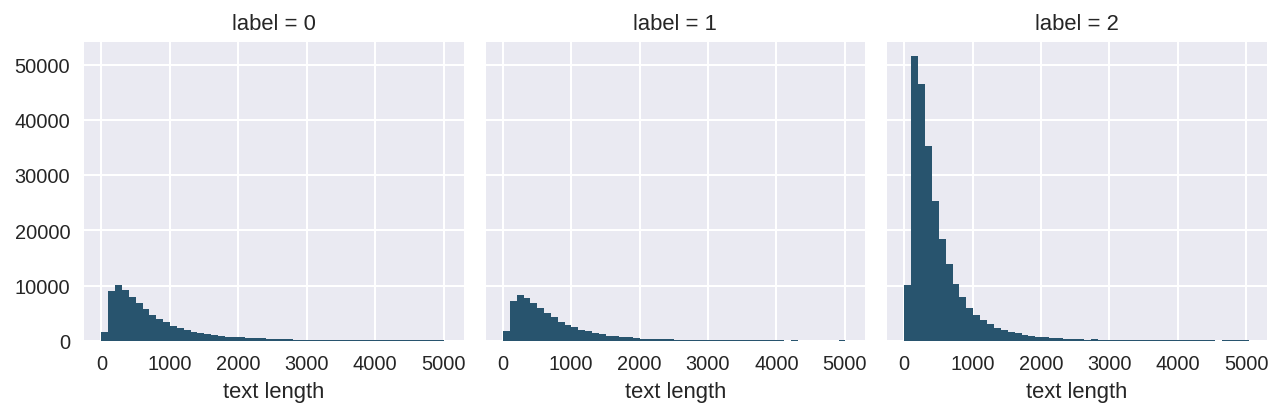

In [57]:
g = sns.FacetGrid(data=train, col='label')
g.map(plt.hist, 'text length', bins=50, color='#28546E')
plt.savefig('label_textlen', dpi=200)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


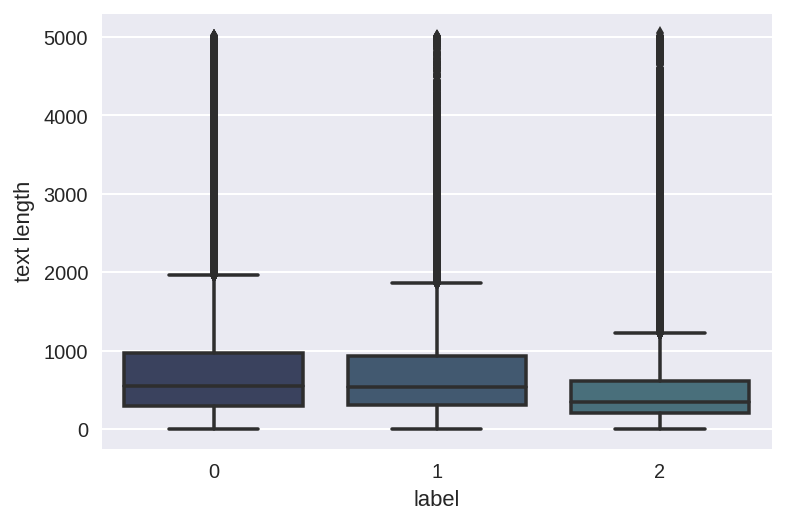

In [58]:
sns.boxplot(x='label', y='text length', data=train, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))
plt.savefig('label_textlen_box', dpi=200)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


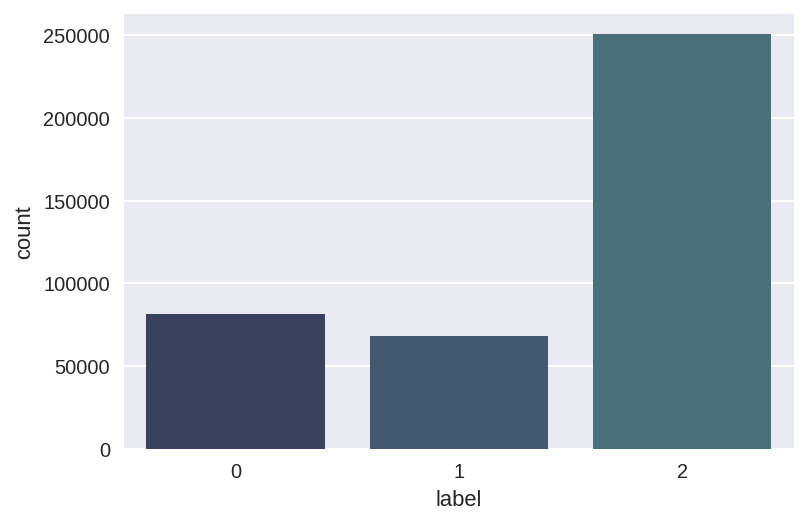

In [59]:
sns.countplot(x='label', data=train, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))

**NLP CLASSIFICATION TASK**

In [60]:
train_class = train[(train['label'] == 0) | (train['label'] == 2) | (train['label'] == 1)]
train_class.head()

,label,text,text length
0,1,Great mobile app with nice reward program. Mak...,643
1,2,Really fast and polite. Definitely recommend. ...,122
2,2,"This place is always amazing, friendly staff a...",140
3,1,We did a Wine 101 class on a Friday night. Coo...,457
4,1,I am rounding up because I think this place ma...,2276


In [61]:
train_class.shape


(400000, 3)

In [62]:
train_class['label'].unique()


array([1, 2, 0])

In [93]:
#X = train_class['text']
#y = train_class['label']
train_class_0 = train[(train['label'] == 0)]
train_class_1 = train[(train['label'] == 1)]
train_class_2 = train[(train['label'] == 2)]
frac0 = 50000/len(train_class_0)
frac1 = 50000/len(train_class_1)
frac2 = 50000/len(train_class_2)
train_class_0 = train_class_0.sample(frac=frac0)
train_class_1 = train_class_1.sample(frac=frac1)
train_class_2 = train_class_2.sample(frac=frac2)
df = train_class_0.append(train_class_1)
df1 = df.append(train_class_2)
train_class = df1.sample(frac=1).reset_index(drop=True)
print(train_class.size)
X = train_class['text']
y = train_class['label']
print(X.size)
print(y.size)
#X = train_class['text'].loc[1:30000]
#y = train_class['label'].loc[1:30000]

450000
150000
150000


In [94]:
X


0         This is a Pizza Hut\/Wing Street. i hate to re...
1         My favorite Chinese restaurant in Pittsburgh! ...
2         As a meat eater: I had "the priest" burger. Th...
3         The booking\/front staff is ok...just ok. Not ...
4         This is one of my favorite places to go to! I ...
5         I would give 1 start for this store.I treated ...
6         Première visite a ce restaurant Vegan. \nSalad...
7         This place was great for $60 a night. I booked...
8         My wife and I stayed at the Southpoint Casino ...
9         Sehr gewöhnungsbedürftiges Ambiente. Absolut k...
10        This location does NOT sell added on.  Remembe...
11        We came here during the lunch break of our wor...
12        My favorite place to grab doubles $1.50 and po...
13        It's a Firkin pub!  That says enough already -...
14        This place really is a 3.5 star restaurant. It...
15        Got there 11:30AM on a Sat..waited 20 mins for...
16        If I could give no stars I wou

** TEXT PROCESSING **

In [0]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [96]:
text_process('If Puru had a brain, he would know that the above function works without having to try it.')

['Puru', 'brain', 'would', 'know', 'function', 'works', 'without', 'try']

** VECTORIZATION **

In [0]:
from sklearn.feature_extraction.text import CountVectorizer


In [0]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [99]:
print(len(bow_transformer.vocabulary_))

207909


In [100]:
review25 = X[25]
print(review25)

Just ate at the new Surprise location for the first time.  As other reviewers have said, it is a very nice upgrade from the prior location.  Overall, we like Babbo and have gone several times, but this time I had a sandwich and I need to write about it.

The "Italiano" sandwich is a mess.  It is a variation on a standard Italian sub (i.e., similar ingredients) but the chef is trying waaaaay too hard to make it unique.  It is on focaccia bread, which in itself isn't a bad thing, but the bread was not cut entirely in half, i.e., it wasn't two slices, one on top of the other.  Instead, it was partially cut open like a submarine sandwich roll, and then stuffed with an architecturally unstable combination of ingredients,  The result is that everything just falls out of the sandwich.  It is a mess to try to eat.

As to the ingredients, they are okay, except for the random globs of tasteless mozzarella cheese.  It added nothing to the flavor and kept just falling out onto the plate.  Also, th

In [101]:
bow25 = bow_transformer.transform([review25])
print(bow25)
print(bow25.shape)

  (0, 11470)	1
  (0, 14667)	2
  (0, 40791)	1
  (0, 41131)	1
  (0, 41143)	1
  (0, 56144)	1
  (0, 71855)	1
  (0, 83324)	1
  (0, 87360)	1
  (0, 88331)	1
  (0, 90046)	1
  (0, 93067)	1
  (0, 95343)	2
  (0, 99788)	1
  (0, 100433)	1
  (0, 100599)	1
  (0, 101678)	1
  (0, 103470)	1
  (0, 108136)	2
  (0, 115526)	2
  (0, 117488)	1
  (0, 118697)	1
  (0, 118956)	1
  (0, 120273)	1
  (0, 120284)	1
  :	:
  (0, 181739)	1
  (0, 181965)	1
  (0, 185586)	1
  (0, 186394)	1
  (0, 187344)	1
  (0, 187508)	1
  (0, 187577)	1
  (0, 189793)	1
  (0, 190183)	1
  (0, 192145)	1
  (0, 193042)	2
  (0, 193190)	1
  (0, 194226)	1
  (0, 195813)	1
  (0, 195835)	1
  (0, 196330)	1
  (0, 197774)	1
  (0, 197877)	1
  (0, 198278)	1
  (0, 198618)	1
  (0, 199400)	1
  (0, 201232)	1
  (0, 202154)	1
  (0, 204868)	1
  (0, 205524)	1
(1, 207909)


In [0]:
#print(bow_transformer.get_feature_names()[11443])
#print(bow_transformer.get_feature_names()[22077])

In [0]:
X = bow_transformer.transform(X)


In [104]:
X

<150000x207909 sparse matrix of type '<class 'numpy.int64'>'
	with 7926693 stored elements in Compressed Sparse Row format>

In [105]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurences: ', X.nnz)

Shape of Sparse Matrix:  (150000, 207909)
Amount of Non-Zero occurences:  7926693


In [106]:
# Number of non-zero messages against total number of messages
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('density: {}'.format((density)))


density: 0.025417187327147935


** TRAINING DATA, TESTING DATA SPLIT**

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

** BUILDING AND TRAINING MODEL **

Model Name = Multinomial Naive Bayes model


In [0]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [116]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Model Name = SVM

In [0]:
from sklearn import svm

In [110]:
lin_clf = svm.LinearSVC(random_state = 0)
lin_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

** PREDICTIONS AND EVALUATIONS **

Predictions

In [0]:
preds = nb.predict(X_test)

In [0]:
preds = lin_clf.predict(X_test)

Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix, classification_report

In [121]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[11953  2868   166]
 [ 1798 12243   997]
 [ 1033  2776 11166]]


             precision    recall  f1-score   support

          0       0.81      0.80      0.80     14987
          1       0.68      0.81      0.74     15038
          2       0.91      0.75      0.82     14975

avg / total       0.80      0.79      0.79     45000



** SANDBOX FOR MAKING PREDICTIONS **

In [0]:
#positive_review = train_class['text'][1]
#positive_review

In [0]:
#positive_review_transformed = bow_transformer.transform([positive_review])
#positive_review_transformed

In [0]:
#nb.predict(positive_review_transformed)[0]

In [0]:
#negative_review = yelp_class['text'][5]
#negative_review

In [0]:
#negative_review_transformed = bow_transformer.transform([negative_review])
#negative_review_transformed

In [0]:
#nb.predict(negative_review_transformed)[0]